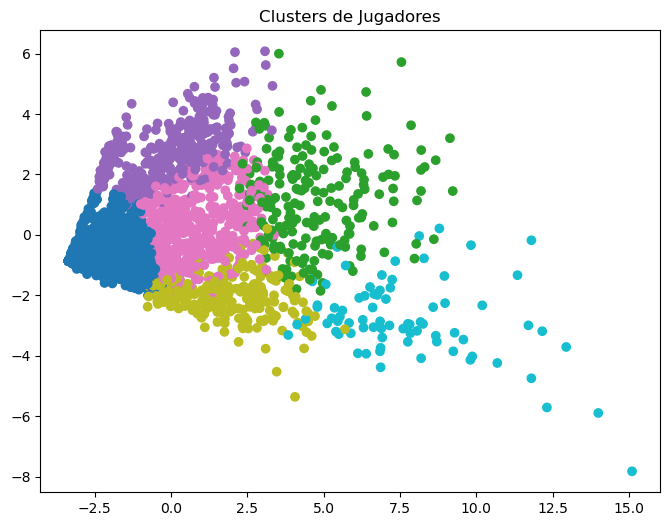

                 Player    Pos            PlayerStyle
0      Brenden Aaronson  FW,MF     9 Goleador de Área
1   Jones El-Abdellaoui  MF,FW     Interior Conductor
2         Himad Abdelli     MF  Organizador / Regista
3              Ali Abdi  DF,MF     Defensa Posicional
4     Salis Abdul Samed     MF         Interior Mixto
5       Saud Abdulhamid     DF     Defensa Posicional
6       Laurent Abergel     MF  Organizador / Regista
7        Matthis Abline  FW,MF     9 Goleador de Área
8                 Abner     DF    Central Constructor
9     Zakaria Aboukhlal  FW,MF    Atacante Asociativo
10          Abdel Abqar     DF    Defensa Contundente
11          Francis Abu     MF       Pivote Defensivo
12    Giorgi Abuashvili  FW,MF    Atacante Asociativo
13     Francesco Acerbi     DF    Central Constructor
14          Ragnar Ache     FW     9 Goleador de Área
15    Joshua Acheampong     DF     Defensa Posicional
16           Akor Adams     FW     9 Goleador de Área
17            Che Adams  FW,

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv('dataset_con_fatiga.csv')

# Variables de clustering
cluster_vars = [
    'PrgDist','Carries','PrgP','PrgR',
    'Att_stats_possession','Succ',
    'xG','xAG',
    'Tkl+Int','Blocks',
    'Crs','KP','PrgC','Touches','Sh'
]

X = df[cluster_vars].fillna(0)

# Clustering

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=6, random_state=42)
df['PlayerCluster'] = kmeans.fit_predict(X_scaled)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['PlayerCluster'], cmap='tab10')
plt.title('Clusters de Jugadores')
plt.show()

# Percentiles
percentiles = df[cluster_vars].quantile([0.4, 0.5, 0.6])

# Detectar línea USANDO POS
def detectar_linea(row):
    pos = row['Pos']

    if pos.startswith('DF'):
        return 'Defensa'
    elif pos.startswith('MF'):
        return 'Mediocampo'
    elif pos.startswith('FW'):
        return 'Ataque'
    else:
        return 'Mediocampo'

# Asignar estilo REAL
def asignar_estilo_jugador(row, p):
    linea = detectar_linea(row)

    # ATAQUE
    if linea == 'Ataque':

        if row['xG'] > p.loc[0.6,'xG'] and row['Sh'] > p.loc[0.6,'Sh']:
            return '9 Goleador de Área'

        if row['Succ'] > p.loc[0.6,'Succ'] and row['Carries'] > p.loc[0.6,'Carries']:
            return 'Extremo Desequilibrante'

        if row['xAG'] > p.loc[0.6,'xAG'] or row['KP'] > p.loc[0.6,'KP']:
            return 'Segundo Delantero / Asistidor'

        return 'Atacante Asociativo'

    # MEDIOCAMPO
    if linea == 'Mediocampo':

        if row['PrgP'] > p.loc[0.6,'PrgP'] and row['KP'] > p.loc[0.5,'KP']:
            return 'Organizador / Regista'

        if row['PrgC'] > p.loc[0.6,'PrgC']:
            return 'Interior Conductor'

        if row['Tkl+Int'] > p.loc[0.6,'Tkl+Int']:
            return 'Pivote Defensivo'

        return 'Interior Mixto'

    # DEFENSA
    if linea == 'Defensa':

        if row['PrgP'] > p.loc[0.6,'PrgP']:
            return 'Central Constructor'

        if row['Tkl+Int'] > p.loc[0.6,'Tkl+Int']:
            return 'Defensa Contundente'

        return 'Defensa Posicional'

# Aplicar estilos
df['PlayerStyle'] = df.apply(
    lambda row: asignar_estilo_jugador(row, percentiles),
    axis=1
)

# Comprobación
print(df[['Player','Pos','PlayerStyle']].head(20))
print(df['PlayerStyle'].value_counts())

# Guardar
df.to_csv('dataset_con_clusters_y_estilos.csv', index=False)

print(" Estilos corregidos y coherentes con la posición")
